In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm

In [3]:
load_dotenv()
folder_path = os.getenv('file_path_Munch')

In [4]:
folder_path = '/Users/alinamaksimova/Desktop/shadows of mind/dataset/Edvard Munch/paintings'

In [10]:
def preprocess_image(filename, type_of_analysis):
    filepath = os.path.join(folder_path, filename)
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    # image = cv2.resize(image, (512, 512)) 
    if type_of_analysis == 'lines':
        edges = cv2.Canny(image, 100, 200)
        year = filename.split('_')[0]
        return image, edges, year
    elif type_of_analysis == 'circles':
        year = filename.split('_')[0]
        return image, year 

In [11]:
def analyse_lines(folder_path, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=10):
    results = {}
    line_length_for_paintings = {}
    line_length_for_years = {}
    straight_lines_count_for_paintings = {}
    straight_lines_count_for_years = {}
    straight_lines_length_for_years = {}
    
    for filename in tqdm(os.listdir(folder_path)):
        if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
            image, edges, year = preprocess_image(filename, type_of_analysis='lines')
            if year != "yyyy":
                
                # gets lengths of lines for each painting
                edge_length = np.sum(edges > 0)
                height, width = image.shape
                area = height * width
                normalized_length = edge_length / area
                
                line_length_for_paintings[filename] = normalized_length

                # gets lengths of lines for each year
                if year in line_length_for_years:
                    line_length_for_years[year].append(normalized_length)
                else:
                    line_length_for_years[year] = [normalized_length]
                    
                # gets straight lines for each painting
                lines = cv2.HoughLinesP(edges, 
                                        rho, # шаг в пикселях по оси x
                                        theta, # шаг в радианах по углу
                                        threshold, # минимальное количество точек на линии
                                        minLineLength, # минимальная длина линии
                                        maxLineGap) # максимальный разрыв между частями линии
                num_lines = len(lines) if lines is not None else 0
                height, width = image.shape
                area = height * width
                normalized_lines = num_lines / area
                straight_lines_count_for_paintings[filename] = normalized_lines
                
                # gets straight lines for each year
                if year in straight_lines_count_for_years:
                    straight_lines_count_for_years[year].append(normalized_lines)
                else:
                    straight_lines_count_for_years[year] = [normalized_lines]
                    
                # Calculate the average line length for each painting
                total_line_length = 0
                if lines is not None:
                    for line in lines:
                        x1, y1, x2, y2 = line[0]
                        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) # length of a line
                        total_line_length += length

                if year in straight_lines_length_for_years:
                    straight_lines_length_for_years[year].append(total_line_length)
                else:
                    straight_lines_length_for_years[year] = [total_line_length]
    
    averaged_results_year = {year: np.mean(values) for year, values in line_length_for_years.items()}
    sorted_results_year = dict(sorted(averaged_results_year.items(), key=lambda x: int(x[0])))
    
    averaged_results_str_year = {year: np.mean(values) for year, values in straight_lines_count_for_years.items()}
    sorted_results_str_year = dict(sorted(averaged_results_str_year.items(), key=lambda x: int(x[0])))
    
    averaged_results_line_length = {year: np.mean(values) for year, values in straight_lines_length_for_years.items()}
    sorted_results_line_length = dict(sorted(averaged_results_line_length.items(), key=lambda x: int(x[0])))

    results['line_length_for_paintings'] = line_length_for_paintings
    results['line_length_for_year'] = sorted_results_year
    results['straight_lines_count_for_paintings'] = straight_lines_count_for_paintings
    results['straight_lines_count_for_year'] = sorted_results_str_year 
    results['straight_lines_length_for_years'] = sorted_results_line_length
    
    return results

In [7]:
results_lines = analyse_lines(folder_path)

100%|██████████| 224/224 [00:41<00:00,  5.38it/s]


In [12]:
def analyse_circles(folder_path, dp=1.2, minDist=20, param1=50, param2=30, minRadius=10, maxRadius=100):
    results = {}
    circle_count_for_paintings = {}
    circle_count_for_years = {}
    mean_radius_for_years = {}
    
    for filename in tqdm(os.listdir(folder_path)):
        if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
            image, year = preprocess_image(filename, type_of_analysis='circles')
            h, w = image.shape[:2]  
            image_area = h * w 
            
            if year != "yyyy":
                
                # gets count of circles for each painting
                blurred = cv2.GaussianBlur(image, (9, 91), 2)
                circles = cv2.HoughCircles(
                    blurred, 
                    cv2.HOUGH_GRADIENT, 
                    dp, 
                    minDist, 
                    param1, 
                    param2, 
                    minRadius, 
                    maxRadius
                )

                num_circles = 0 if circles is None else len(circles[0])
                
                # gets count of circles for each year
                if year not in circle_count_for_years:
                    circle_count_for_years[year] = 0
                circle_count_for_years[year] += num_circles
                
                circle_count_for_paintings[filename] = num_circles
                
                # gets average radius of circles for year
                
                if year not in mean_radius_for_years:
                    mean_radius_for_years[year] = {"num_circles": 0, "radius_sum": 0, "normalized_radius_sum": 0, "radii": [], "normalized_radii": []}
                    
                if circles is not None:
                    circles = np.round(circles[0, :]).astype("int")

                    for (x, y, r) in circles:
                        normalized_radius = r / np.sqrt(image_area) 

                        mean_radius_for_years[year]["num_circles"] += 1
                        mean_radius_for_years[year]["radius_sum"] += r
                        mean_radius_for_years[year]["normalized_radius_sum"] += normalized_radius
                        mean_radius_for_years[year]["radii"].append(r)
                        mean_radius_for_years[year]["normalized_radii"].append(normalized_radius)
                else:
                    mean_radius_for_years[year]["num_circles"] = 0 
                    mean_radius_for_years[year]["radius_sum"] = 0
                    mean_radius_for_years[year]["normalized_radius_sum"] = 0
                    mean_radius_for_years[year]["radii"] = []
                    mean_radius_for_years[year]["normalized_radii"] = []
    
    for year in mean_radius_for_years:
        if mean_radius_for_years[year]["num_circles"] > 0:
            num_circles = mean_radius_for_years[year]["num_circles"]
            
            # mean radii
            avg_radius = mean_radius_for_years[year]["radius_sum"] / num_circles
            avg_normalized_radius = mean_radius_for_years[year]["normalized_radius_sum"] / num_circles
            
            # std
            radii = np.array(mean_radius_for_years[year]["radii"])
            normalized_radii = np.array(mean_radius_for_years[year]["normalized_radii"])

            std_radius = np.std(radii)  
            std_normalized_radius = np.std(normalized_radii) 

            mean_radius_for_years[year]["average_radius"] = avg_radius
            mean_radius_for_years[year]["average_normalized_radius"] = avg_normalized_radius
            mean_radius_for_years[year]["std_radius"] = std_radius
            mean_radius_for_years[year]["std_normalized_radius"] = std_normalized_radius
        else:
            mean_radius_for_years[year]["average_radius"] = 0
            mean_radius_for_years[year]["average_normalized_radius"] = 0
            mean_radius_for_years[year]["std_radius"] = 0
            mean_radius_for_years[year]["std_normalized_radius"] = 0
        
    results['circle_count_for_paintings'] = circle_count_for_paintings
    results['circle_count_for_years'] = circle_count_for_years
    results['mean_radius_for_years'] = mean_radius_for_years

    return results

In [9]:
results_circles = analyse_circles(folder_path)

100%|██████████| 224/224 [24:01<00:00,  6.43s/it]  


#### Смотрим количество границ на каждой картине

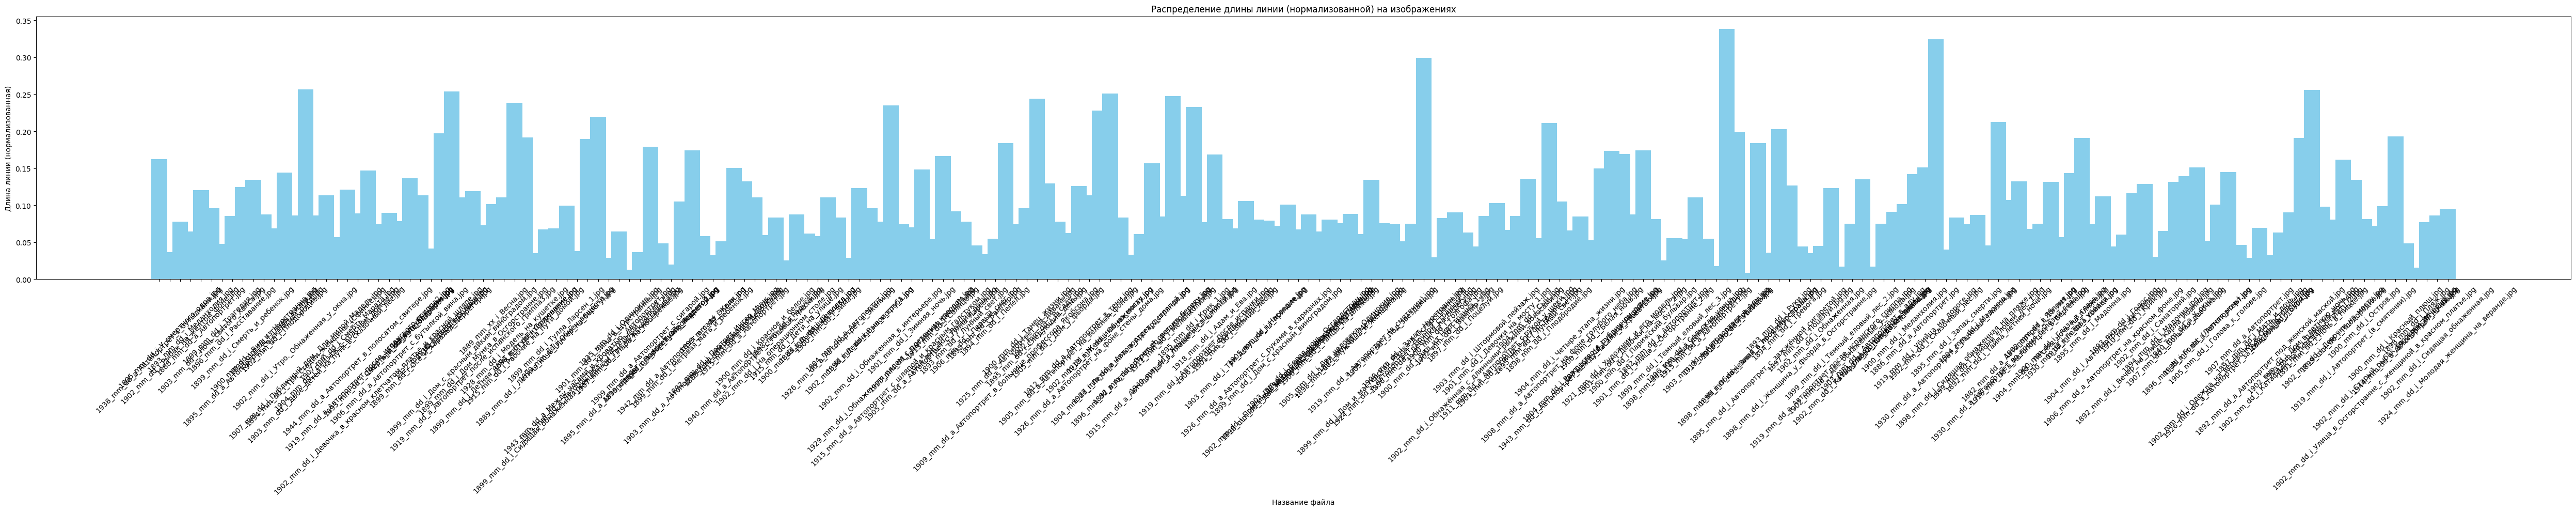

In [258]:
filenames = list(results_lines['line_length_for_paintings'].keys())
values = list(results_lines['line_length_for_paintings'].values())
bar_width = 1.5
plt.figure(figsize=(50, 10))
plt.bar(filenames, values, color='skyblue', width=bar_width)
plt.xlabel('Название файла')
plt.ylabel('Длина линии (нормализованная)')
plt.title('Распределение длины линии (нормализованной) на изображениях')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Смотрим количество границ на картинах за год

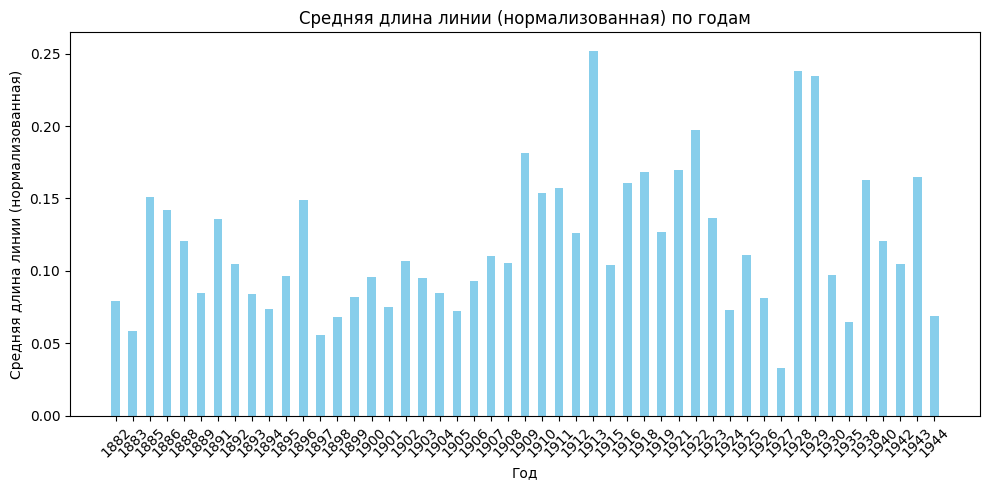

In [259]:
years = list(results_lines['line_length_for_year'].keys())
values = list(results_lines['line_length_for_year'].values())
bar_width = 0.5
plt.figure(figsize=(10, 5))
plt.bar(years, values, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Средняя длина линии (нормализованная)')
plt.title('Средняя длина линии (нормализованная) по годам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Смотрим количество прямых линий на каждой картине

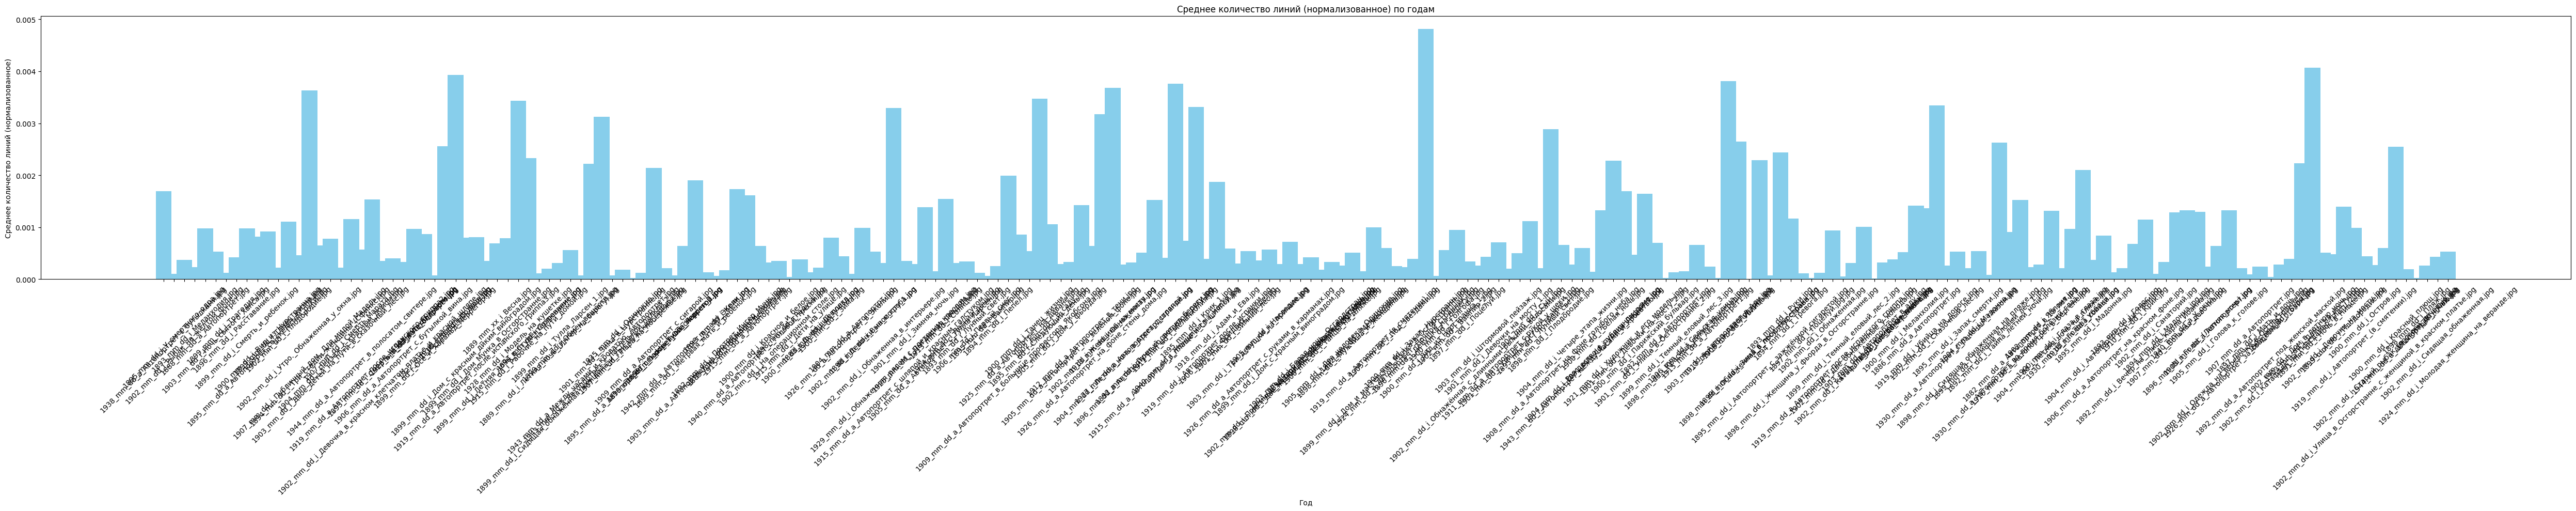

In [260]:
years = list(results_lines['straight_lines_count_for_paintings'].keys())
values = list(results_lines['straight_lines_count_for_paintings'].values())
bar_width = 1.5
plt.figure(figsize=(50, 10))
plt.bar(years, values, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Среднее количество линий (нормализованное)')
plt.title('Среднее количество линий (нормализованное) по годам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Смотрим количество прямых линий по годам

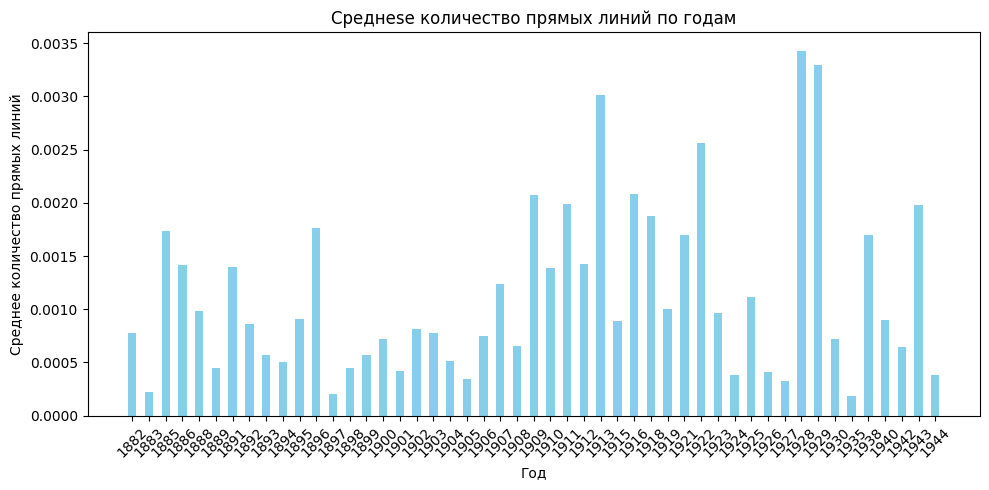

In [262]:
years = list(results_lines['straight_lines_count_for_year'].keys())
values = list(results_lines['straight_lines_count_for_year'].values())
bar_width = 0.5
plt.figure(figsize=(10, 5))
plt.bar(years, values, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Среднее количество прямых линий')
plt.title('Среднеsе количество прямых линий по годам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Смотрим среднюю длину прямых линий за год

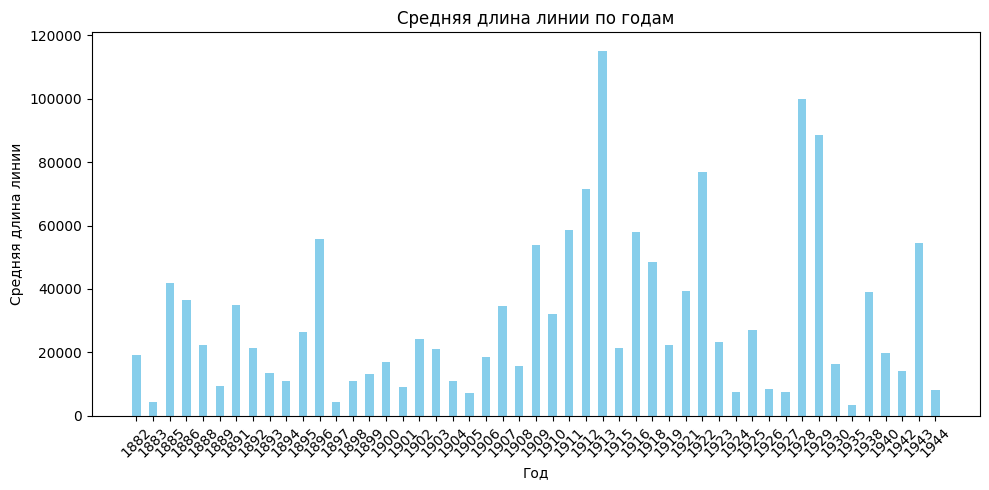

In [264]:
years = list(results_lines['straight_lines_length_for_years'].keys())
values = list(results_lines['straight_lines_length_for_years'].values())
bar_width = 0.5
plt.figure(figsize=(10, 5))
plt.bar(years, values, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Средняя длина линии')
plt.title('Средняя длина линии по годам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Смотрим количество кружков на каждой картине

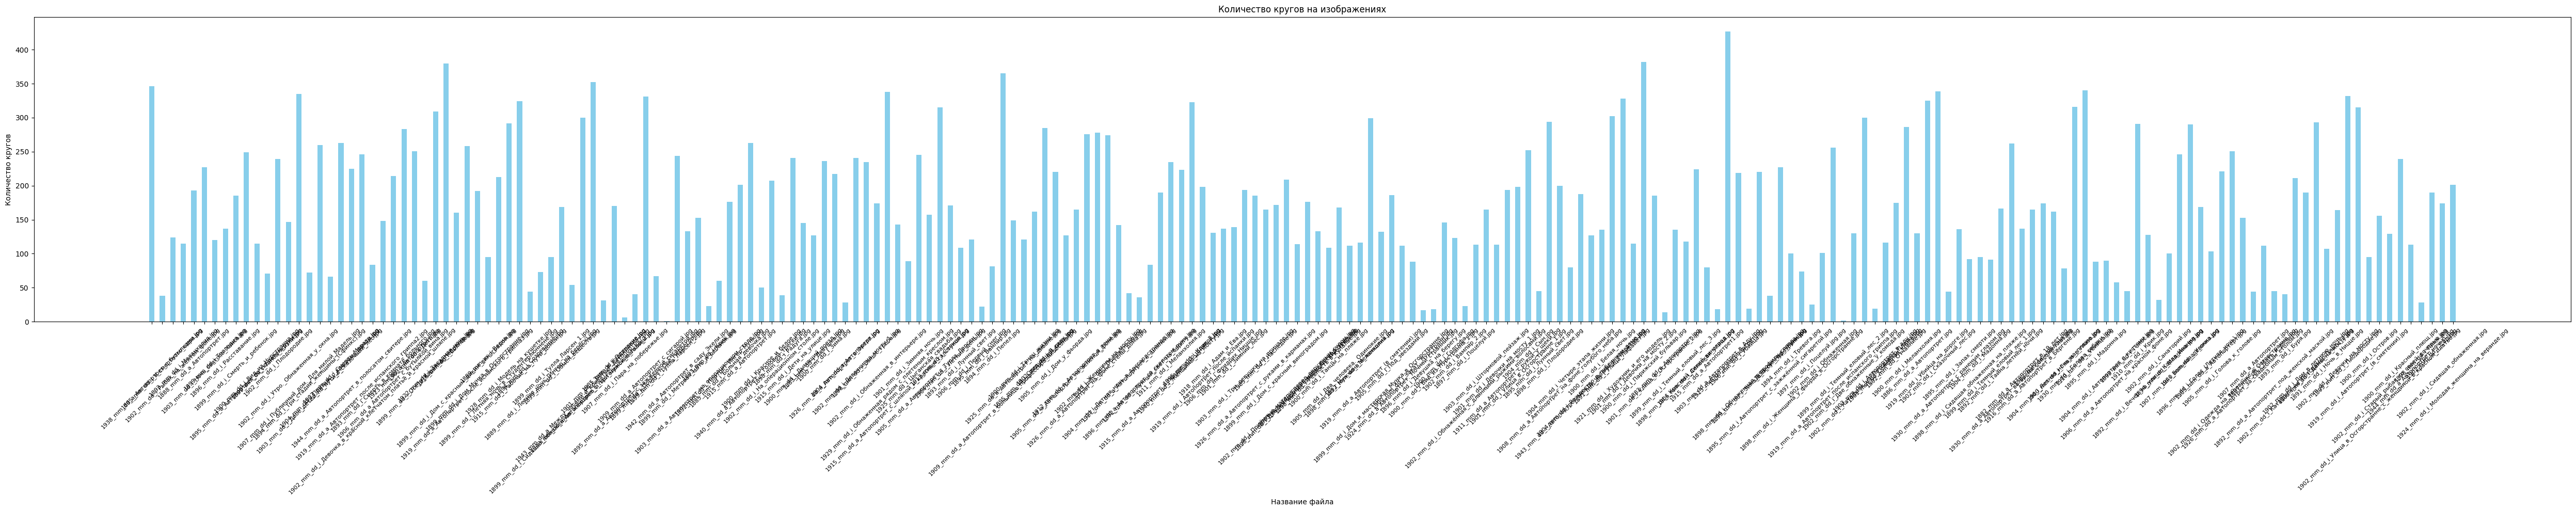

In [265]:
filenames = list(results_circles['circle_count_for_paintings'].keys())
values = list(results_circles['circle_count_for_paintings'].values())
bar_width = 0.5
plt.figure(figsize=(50, 10))
plt.bar(filenames, values, color='skyblue', width=bar_width)
plt.xlabel('Название файла')
plt.ylabel('Количество кругов')
plt.title('Количество кругов на изображениях')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

#### Смотрим количество кружков за каждый год

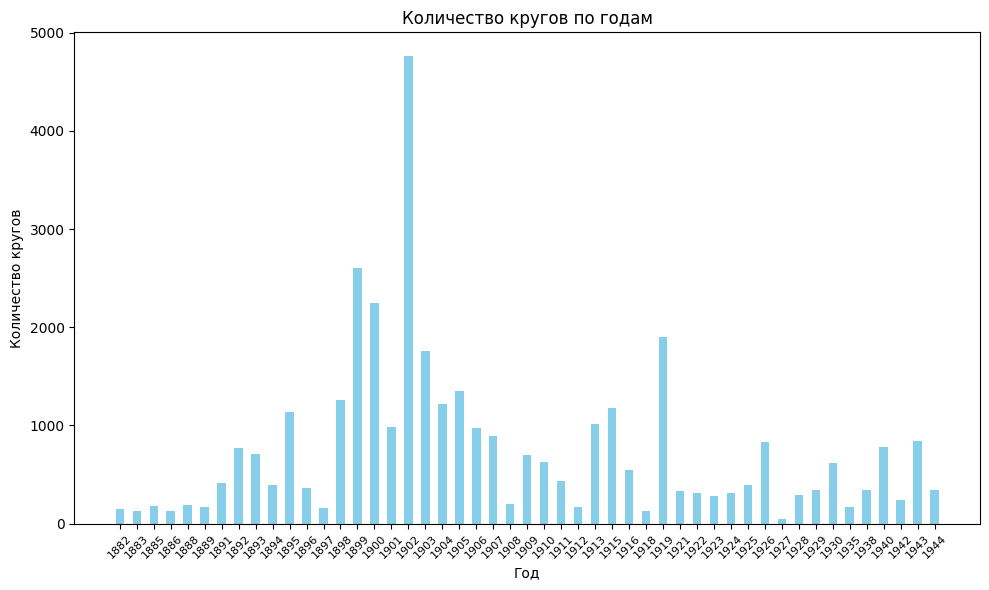

In [266]:
sorted_results = dict(sorted(results_circles['circle_count_for_years'].items()))

years = list(sorted_results.keys())
values = list(sorted_results.values())
bar_width = 0.5
plt.figure(figsize=(10, 6))
plt.bar(years, values, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Количество кругов')
plt.title('Количество кругов по годам')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

## Смотрим средний радиус кружков

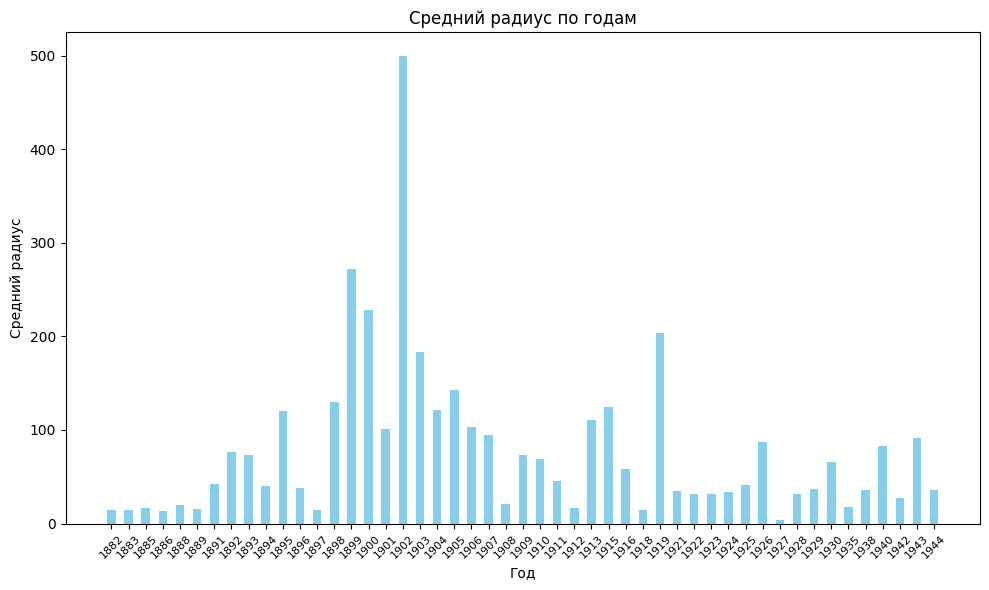

In [299]:
results_count_normalized_radius_sum = {year: data['normalized_radius_sum'] for year, data in results_circles['mean_radius_for_years'].items()}

sorted_results_results_count_normalized_radius_sum = dict(sorted(results_count_normalized_radius_sum.items()))
years_results_count_normalized_radius_sum = list(sorted_results_results_count_normalized_radius_sum.keys())
values_results_count_normalized_radius_sum = list(sorted_results_results_count_normalized_radius_sum.values())
bar_width = 0.5
plt.figure(figsize=(10, 6))
plt.bar(years_results_count_normalized_radius_sum, values_results_count_normalized_radius_sum, color='skyblue', width=bar_width)
plt.xlabel('Год')
plt.ylabel('Средний радиус')
plt.title('Средний радиус по годам')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

## Смотрим среднеквадратичное отклонение

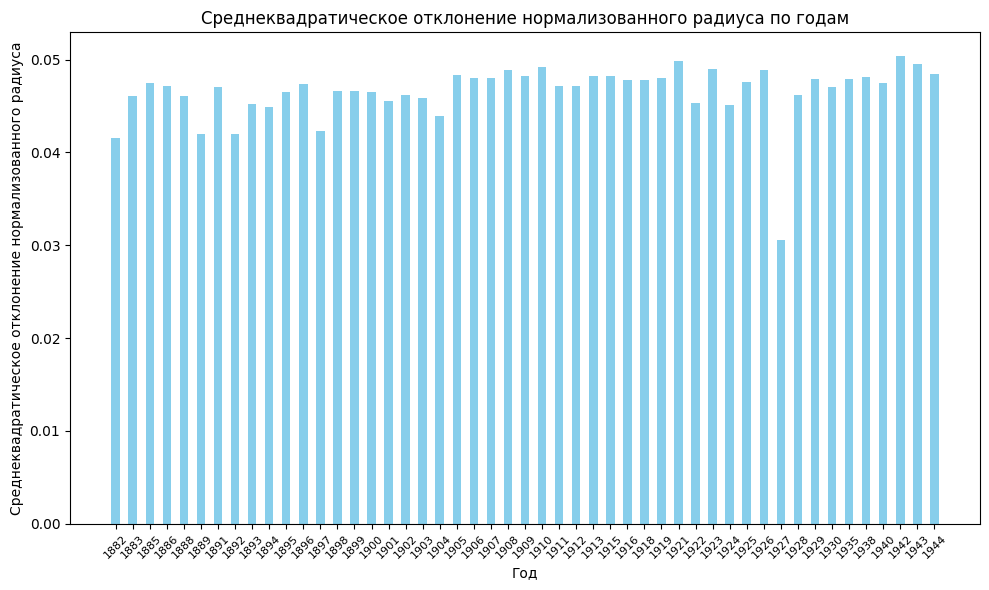

In [302]:
results_count_std_normalized_radius = {year: data["std_normalized_radius"] for year, data in results_circles['mean_radius_for_years'].items()}

sorted_results_std_normalized_radius = dict(sorted(results_count_std_normalized_radius.items())) 
years_std_normalized_radius = list(sorted_results_std_normalized_radius.keys()) 
values_std_normalized_radius = list(sorted_results_std_normalized_radius.values())

bar_width = 0.5
plt.figure(figsize=(10, 6))
plt.bar(years_std_normalized_radius, values_std_normalized_radius, color='skyblue', width=bar_width)
    
plt.xlabel('Год')
plt.ylabel('Среднеквадратическое отклонение нормализованного радиуса')
plt.title('Среднеквадратическое отклонение нормализованного радиуса по годам')

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

## Собираем в датасет

In [269]:
import pandas as pd

In [271]:
for i in results_lines:
    print(i)

line_length_for_paintings
line_length_for_year
straight_lines_count_for_paintings
straight_lines_count_for_year
straight_lines_length_for_years


In [278]:
line_length_for_year = pd.DataFrame(list(results_lines['line_length_for_year'].items()), columns=['year', 'line_length'])
len(line_length_for_year)

49

In [279]:
straight_lines_count_for_year = pd.DataFrame(list(results_lines['straight_lines_count_for_year'].items()), columns=['year', 'straight_lines_count'])
len(straight_lines_count_for_year)

49

In [ ]:
straight_lines_length_for_years = pd.DataFrame(list(results_lines['straight_lines_length_for_years'].items()), columns=['year', 'straight_lines_length'])
len(straight_lines_length_for_years)

49

In [286]:
for i in results_circles:
    print(i)

circle_count_for_paintings
circle_count_for_years
mean_radius_for_years


In [289]:
circle_count_for_years = pd.DataFrame(list(results_circles['circle_count_for_years'].items()), columns=['year', 'circle_count'])
len(circle_count_for_years)

49

In [306]:
normalized_radius_sum = pd.DataFrame({
    "year": years_results_count_normalized_radius_sum,
    "normalized_radius_sum": values_results_count_normalized_radius_sum
})

len(normalized_radius_sum)

49

In [303]:
std_normalized_radius = pd.DataFrame({
    "year": years_std_normalized_radius,
    "normalized_radius_sum": values_std_normalized_radius
})

len(std_normalized_radius)

49

In [310]:
df_merged = line_length_for_year.merge(straight_lines_count_for_year, on="year", how="outer").merge(straight_lines_length_for_years, on="year", how="outer")
df_merged = df_merged.merge(circle_count_for_years, on="year", how="outer") #.merge(normalized_radius_sum, on="year", how="outer")
df_merged = df_merged.merge(std_normalized_radius, on="year", how="outer")

df_merged = df_merged.sort_values("year").reset_index(drop=True)

df_merged.head()

year  line_length  straight_lines_count  straight_lines_length  \
0  1882     0.078886              0.000772           19098.320525   
1  1883     0.058533              0.000225            4216.292051   
2  1885     0.150776              0.001736           41927.182386   
3  1886     0.141838              0.001411           36577.024363   
4  1888     0.120445              0.000980           22464.292472   

   circle_count  normalized_radius_sum  
0           151               0.041514  
1           127               0.046067  
2           176               0.047528  
3           130               0.047107  
4           193               0.046078

In [283]:
len(df_merged)

49

In [311]:
df_merged.to_csv('dataset_lines_circles.csv', index=False)